In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from libpysal import graph

In [3]:
suburbanisation = gpd.read_file("zony_suburbanizace_2008_2016.zip")

Set the index. In this case, you can potentially use the default as both are just integers. Note that "obec_nazev" is not unique so it will produce erroneous results.

In [4]:
suburbanisation = suburbanisation.set_index("OBJECTID")

Create a contiguity matrix using the queen criterion

In [5]:
queen = graph.Graph.build_contiguity(suburbanisation, rook=False)

Let’s focus on Prague (ID 891 in the table). How many neighbours does it have?

In [6]:
len(queen[891])

38

In [7]:
queen.cardinalities[891]

38

Reproduce the previous section’s zoom plot with Prague and its neighbours. Can you make that plot as both static and interactive maps?

In [10]:
m = suburbanisation.loc[queen[891].index].explore(color="#25b497")
suburbanisation.loc[[891]].explore(m=m, color="#fa94a5")

<Axes: >

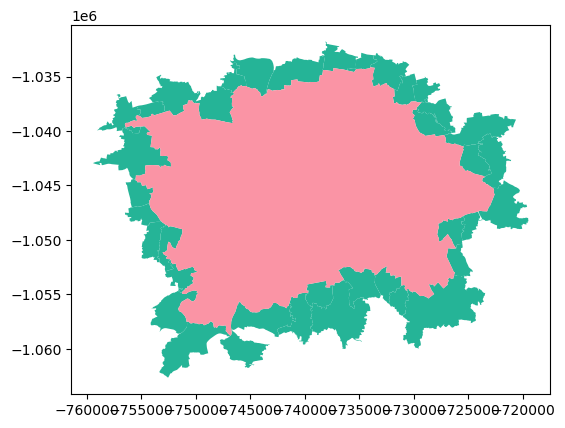

In [9]:
ax = suburbanisation.loc[queen[891].index].plot(color="#25b497")
suburbanisation.loc[[891]].plot(ax=ax, color="#fa94a5")

Create a block spatial weights matrix where every geometry is connected to other geometries in the NUTS2 region. For that, use the NUTS2_kod column of the table.

In [11]:
nuts = graph.Graph.build_block_contiguity(suburbanisation["NUTS2_kod"])

Create KNN weights with 5 neighbours. Remember that KNN expects point geometry.

In [12]:
knn5 = graph.Graph.build_knn(suburbanisation.set_geometry(suburbanisation.centroid), k=5)

Compare the number of neighbours by geometry for the three weights matrices. Which one has more? Why?

In [13]:
# Prague 
knn5.cardinalities[891]

5

In [14]:
nuts.cardinalities[891]

0

Prague is a NUTS2 region by itself. See the data plotted by NUTS2:

<Axes: >

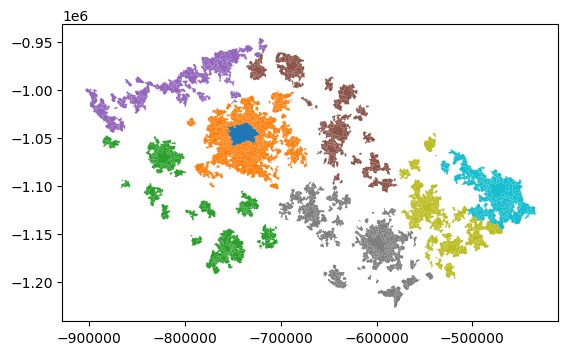

In [15]:
suburbanisation.plot("NUTS2_kod")

In [16]:
#For whole data frame
nuts.cardinalities.mean()

308.5195652173913

In [17]:
knn5.cardinalities.mean()

5.0

Let’s have a look at spatial lag. Before proceeding, you will probably need to pre-process the column with the population (“obyv_31122”) since it comes as string. Assuming the GeoDataFrame is called suburbanisation, you can do the following to cast it to float.

In [18]:
suburbanisation["obyv_31122"] = (
    suburbanisation["obyv_31122"].replace("?", None).astype(float)
)

Measure spatial lag (as mean, so don’t forget to standardise your weights) of the “obyv_31122” column using all weights matrices you have created.

In [20]:
queen_r = queen.transform("R")
nuts_r = nuts.transform("R")
knn_r = knn5.transform("R")

# Prague is too extreme, let's log it
suburbanisation["obyv_log"] = np.log(suburbanisation["obyv_31122"])

suburbanisation["queen_lag"] = queen_r.lag(suburbanisation["obyv_log"])
suburbanisation["nuts_lag"] = nuts_r.lag(suburbanisation["obyv_log"])
suburbanisation["knn_lag"] = knn_r.lag(suburbanisation["obyv_log"])

What is the difference in results for Prague? Do you know why?

In [21]:
suburbanisation.loc[891, ["queen_lag", "nuts_lag", "knn_lag"]]

queen_lag     7.24634
nuts_lag     6.973222
knn_lag      7.515202
Name: 891, dtype: object